In [1]:
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

from pathlib import Path

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [2]:
path = Path('/home/heye0507/wheat_detection/data')

In [3]:
df = pd.read_csv(path/'train.csv')
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [4]:
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)

In [5]:
df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [6]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = df[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = df[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/opt/conda/envs/fastai2/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [7]:
df_folds.head()

,bbox_count,source,stratify_group,fold
image_id,,,,
00333207f,55,arvalis_1,arvalis_1_3,1
005b0d8bb,20,usask_1,usask_1_1,3
006a994f7,25,inrae_1,inrae_1_1,1
00764ad5d,41,inrae_1,inrae_1_2,0
00b5fefed,25,arvalis_3,arvalis_3_1,3


In [8]:
def get_train_transforms():
    return A.Compose(
        [
#             A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
#             A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
#             A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [9]:
TRAIN_ROOT_PATH = path/'train'

In [10]:
class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        image, boxes = self.load_image_and_boxes(index)
#         if self.test or random.random() > 0.5:
#             image, boxes = self.load_image_and_boxes(index)
#         else:
#             image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

#     def load_cutmix_image_and_boxes(self, index, imsize=1024):
#         """ 
#         This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
#         Refactoring and adaptation: https://www.kaggle.com/shonenkov
#         """
#         w, h = imsize, imsize
#         s = imsize // 2
    
#         xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
#         indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

#         result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
#         result_boxes = []

#         for i, index in enumerate(indexes):
#             image, boxes = self.load_image_and_boxes(index)
#             if i == 0:
#                 x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
#                 x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
#             elif i == 1:  # top right
#                 x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
#                 x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
#             elif i == 2:  # bottom left
#                 x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
#                 x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
#             elif i == 3:  # bottom right
#                 x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
#                 x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
#             result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
#             padw = x1a - x1b
#             padh = y1a - y1b

#             boxes[:, 0] += padw
#             boxes[:, 1] += padh
#             boxes[:, 2] += padw
#             boxes[:, 3] += padh

#             result_boxes.append(boxes)

#         result_boxes = np.concatenate(result_boxes, 0)
#         np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
#         result_boxes = result_boxes.astype(np.int32)
#         result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
#         return result_image, result_boxes

In [11]:
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    marking=df,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    marking=df,
    transforms=get_valid_transforms(),
    test=True,
)

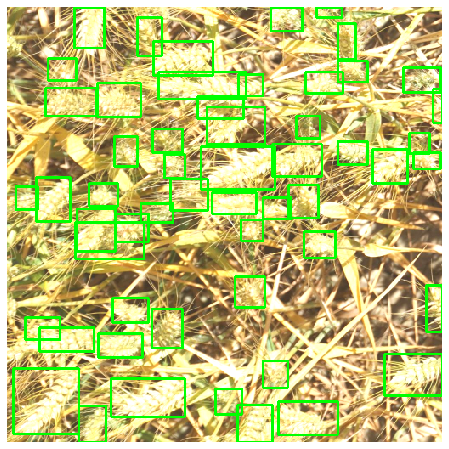

In [20]:
image, target, image_id = train_dataset[0]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image);

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [13]:
import warnings
warnings.filterwarnings("ignore")

class Fitter:
    
    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'/home/heye0507/wheat_detection/model/{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10**5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ] 

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]
                
                target_gt = {}
                target_gt['bbox'] = boxes
                target_gt['cls'] = labels

                output = self.model(images, target_gt)
                loss = output['loss']
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            
            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            
            target_gt = {}
            target_gt['bbox'] = boxes
            target_gt['cls'] = labels

            self.optimizer.zero_grad()
            
            output = self.model(images, target_gt)
            loss = output['loss']
            
            loss.backward()

            summary_loss.update(loss.detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
        
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [14]:
class TrainGlobalConfig:
    num_workers = 4
    batch_size = 4 
    n_epochs = 20 # n_epochs = 40
    lr = 0.0002

    folder = 'effdet0-baseline'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = True  # do scheduler.step after optimizer.step
    validation_scheduler = False  # do scheduler.step after validation stage loss

    SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    scheduler_params = dict(
        max_lr=0.001,
        epochs=n_epochs,
        steps_per_epoch=int(len(train_dataset) / batch_size),
        pct_start=0.1,
        anneal_strategy='cos', 
        final_div_factor=10**5
    )
    
#     SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
#     scheduler_params = dict(
#         mode='min',
#         factor=0.5,
#         patience=1,
#         verbose=False, 
#         threshold=0.0001,
#         threshold_mode='abs',
#         cooldown=0, 
#         min_lr=1e-8,
#         eps=1e-08
#     )

In [15]:
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [16]:
import torch
import torch.nn as nn
from timm.utils import ModelEma
from effdet.anchors import Anchors, AnchorLabeler, generate_detections, MAX_DETECTION_POINTS
from effdet.loss import DetectionLoss

class DetBenchTrain(nn.Module):
    def __init__(self, model, config):
        super(DetBenchTrain, self).__init__()
        self.config = config
        self.model = model
        self.anchors = Anchors(
            config.min_level, config.max_level,
            config.num_scales, config.aspect_ratios,
            config.anchor_scale, config.image_size)
        self.anchor_labeler = AnchorLabeler(self.anchors, config.num_classes, match_threshold=0.5)
        self.loss_fn = DetectionLoss(self.config)

    def forward(self, x, target):
        class_out, box_out = self.model(x)
        cls_targets, box_targets, num_positives = self.anchor_labeler.batch_label_anchors(
            x.shape[0], target['bbox'], target['cls'])
        loss, class_loss, box_loss = self.loss_fn(class_out, box_out, cls_targets, box_targets, num_positives)
        output = dict(loss=loss, class_loss=class_loss, box_loss=box_loss)
#         if not self.training:
#             # if eval mode, output detections for evaluation
#             class_out, box_out, indices, classes = _post_process(self.config, class_out, box_out)
#             output['detections'] = _batch_detection(
#                 x.shape[0], class_out, box_out, self.anchors.boxes, indices, classes,
#                 target['img_scale'], target['img_size'])
        return output

In [17]:
from effdet import get_efficientdet_config, EfficientDet
from effdet.efficientdet import HeadNet

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d0')
    net = EfficientDet(config, pretrained_backbone=True)
    #checkpoint = torch.load('../input/efficientdet/efficientdet_d5-ef44aea8.pth')
    #net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()

In [28]:
run_training()

Fitter prepared. Device is cuda:0

2020-06-21T06:18:50.149772
LR: 3.9999999999999996e-05
[RESULT]: Train. Epoch: 0, summary_loss: 6.14190, time: 202.10138
[RESULT]: Val. Epoch: 0, summary_loss: 1.01541, time: 16.73271

2020-06-21T06:22:29.292622
LR: 0.0005205597491209891
[RESULT]: Train. Epoch: 1, summary_loss: 0.73177, time: 202.65058
[RESULT]: Val. Epoch: 1, summary_loss: 0.58777, time: 15.58177

2020-06-21T06:26:07.859399
LR: 0.0009999999832361111
[RESULT]: Train. Epoch: 2, summary_loss: 0.56093, time: 198.35484
[RESULT]: Val. Epoch: 2, summary_loss: 0.49440, time: 15.63024

2020-06-21T06:29:42.370855
LR: 0.0009923813798662492
[RESULT]: Train. Epoch: 3, summary_loss: 0.51068, time: 198.06203
[RESULT]: Val. Epoch: 3, summary_loss: 0.47858, time: 15.67307

2020-06-21T06:33:16.408821
LR: 0.0009698020235030504
[RESULT]: Train. Epoch: 4, summary_loss: 0.48754, time: 197.82595
[RESULT]: Val. Epoch: 4, summary_loss: 0.45115, time: 15.58732

2020-06-21T06:36:50.213519
LR: 0.0009329479764639

In [18]:
val_loader = torch.utils.data.DataLoader(
    validation_dataset, 
    batch_size=TrainGlobalConfig.batch_size,
    num_workers=TrainGlobalConfig.num_workers,
    shuffle=False,
    sampler=SequentialSampler(validation_dataset),
    pin_memory=False,
    collate_fn=collate_fn,
)

In [22]:
from effdet import DetBenchPredict
import gc

In [23]:
def load_model(model_path):
    config = get_efficientdet_config('tf_efficientdet_d0')
    model = EfficientDet(config,pretrained_backbone=False)
    
    config.num_classes = 1
    config.image_size=512
    model.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    del checkpoint
    gc.collect()
    
    model = DetBenchPredict(model,config)
    model.eval()
    return model.cuda()

In [24]:
model = load_model('/home/heye0507/wheat_detection/model/effdet0-baseline/best-checkpoint-017epoch.bin')

In [31]:
def make_predictions(images, score_threshold=0.22):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = model(images, torch.tensor([1]*images.shape[0]).float().cuda(),
                    torch.tensor([(512,512)]*images.shape[0]).float().cuda()
                   )
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]

In [32]:
def run_wbf(predictions, image_index, image_size=512, iou_thr=0.44, skip_box_thr=0.43, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

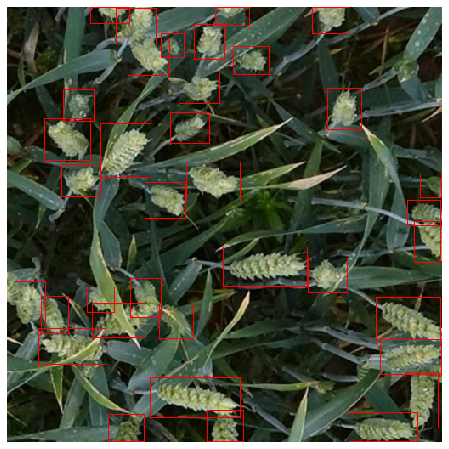

In [35]:
import matplotlib.pyplot as plt
from ensemble_boxes import weighted_boxes_fusion

for j, (images, targets,image_ids) in enumerate(val_loader):
    break

predictions = make_predictions(images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample);

In [36]:
boxes

array([[110, 137, 169, 200],
       [ 44, 131,  98, 180],
       [142,  36, 191,  80],
       [439, 391, 511, 432],
       [377,  95, 417, 144],
       [468, 430, 507, 495],
       [211, 182, 274, 229],
       [434, 341, 510, 391],
       [162, 206, 210, 248],
       [220,  20, 256,  61],
       [168, 436, 274, 483],
       [ 64, 185, 110, 223],
       [402, 477, 483, 511],
       [354, 295, 400, 336],
       [471, 227, 510, 257],
       [254, 282, 353, 328],
       [  9, 323,  45, 375],
       [128,   1, 175,  43],
       [ 66,  97, 102, 134],
       [202,  76, 250, 113],
       [192, 124, 238, 160],
       [479, 252, 510, 300],
       [359,   0, 402,  31],
       [179, 349, 219, 390],
       [235, 474, 278, 511],
       [ 37, 378, 116, 420],
       [266,  46, 308,  79],
       [145, 319, 181, 365],
       [ 40, 340,  72, 384],
       [100, 348, 162, 389],
       [119, 479, 161, 511],
       [ 98,   0, 144,  19],
       [486, 196, 511, 224],
       [ 94, 329, 126, 359],
       [245,  

In [41]:
targets[0]['boxes']

tensor([[128.0000,  44.5000, 181.5000, 101.0000],
        [141.0000, 108.0000, 200.5000, 170.5000],
        [  0.0000,  98.5000,  17.0000, 139.5000],
        [279.0000, 252.0000, 321.0000, 352.0000],
        [180.5000, 209.5000, 229.0000, 278.0000],
        [121.5000, 192.0000, 163.0000, 238.5000],
        [ 92.0000, 377.0000, 150.0000, 419.0000],
        [205.0000, 164.5000, 247.5000, 214.5000],
        [ 20.5000, 218.5000,  61.5000, 256.0000],
        [438.5000, 169.0000, 481.0000, 277.0000],
        [  0.0000, 129.0000,  38.0000, 175.0000],
        [ 31.5000, 137.0000,  83.0000, 194.5000],
        [389.0000, 437.5000, 425.5000, 512.0000],
        [293.5000, 354.0000, 333.5000, 399.0000],
        [181.5000,  64.0000, 218.5000, 107.5000],
        [480.0000, 405.5000, 512.0000, 486.0000],
        [  0.0000, 359.5000,  31.5000, 403.5000],
        [ 72.5000, 200.5000, 114.5000, 250.5000],
        [ 44.5000, 264.5000,  82.0000, 309.5000],
        [375.0000,  38.0000, 418.5000, 115.0000],


In [44]:
calculate_precision(targets[0]['boxes'].numpy(),boxes,form='pascal_voc')

0.013157894736842105

In [45]:
res =[]
for images, targets, image_id in val_loader:
    predictions = make_predictions(images)
    for i, (image,target) in enumerate(zip(images,targets)):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        res.append(calculate_precision(target['boxes'].numpy(),boxes,form='pascal_voc'))

In [46]:
np.mean(res)

0.02733634018333398

In [37]:
from numba import jit

In [38]:
# code from kaggle https://www.kaggle.com/pestipeti/competition-metric-details-script/data
@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision